#### Knowing to Known

The objective of this notebook is to find a crucial measure that using layer a_J we can found clear quantity that distinguish from which we sample and MAYBE this gave to us a notion of how much it knows about itself!

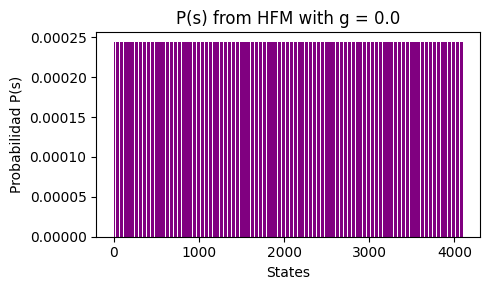

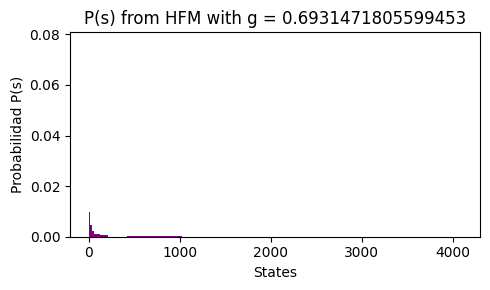

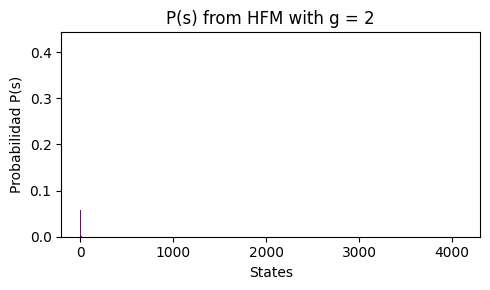

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- MODEL HFM ---
def H_model_distribution(n, g):
    all_states = [np.array([int(x) for x in format(i, f'0{n}b')]) for i in range(2**n)]
    # in the state (0, 0, ..., 0) -> ms=0, in state (1, 0, ..., 0) -> ms=1, else =1 is the p(s=(0,0,0))=1
    energies = np.array([np.exp(-g * max(np.max(np.where(s == 1)[0] + 1) - 1, 0)) if np.any(s) else 1.0 for s in all_states])
    Z = np.sum(energies)
    probs = energies / Z
    return all_states, probs

def plot_HFM_distribution(n,g):
    states, probs = H_model_distribution(n=n, g=g)
    state_labels = [''.join(map(str, s)) for s in states]
    sorted_indices = np.argsort(probs)[::-1]
    plt.figure(figsize=(5, 3))
    plt.bar(range(len(states)), np.array(probs)[sorted_indices], color='purple')
    plt.title(f"P(s) from HFM with g = {g}")
    plt.xlabel("States")
    plt.ylabel("Probabilidad P(s)")
    plt.tight_layout()
    plt.show()

plot_HFM_distribution(n=12, g=0.0)
plot_HFM_distribution(n=12, g=np.log(2))
plot_HFM_distribution(n=12, g=2)

#### Layer Dynamics

$
a^j_t = (1 - \epsilon) a^j_{t-1} + \epsilon \cdot \sigma\left( \sum_i w^j_i \cdot s_i(t) \right)
$

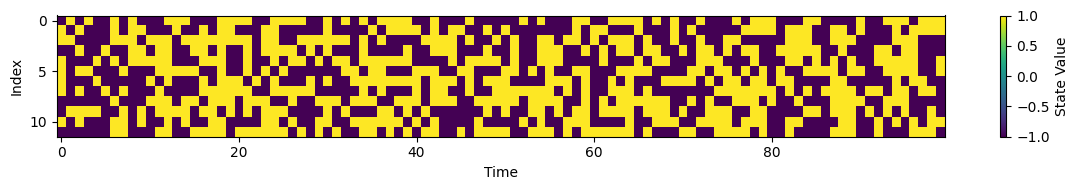

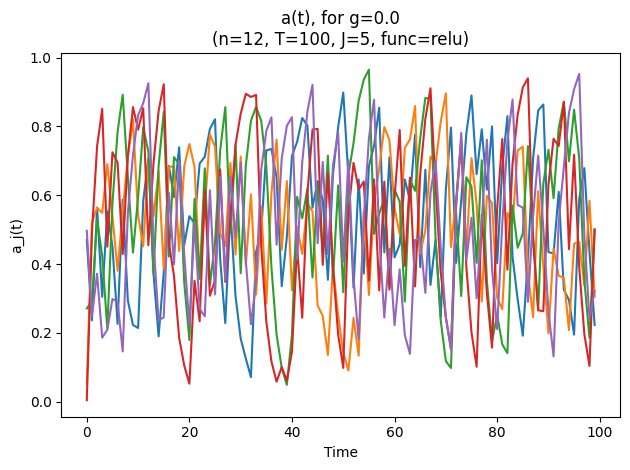

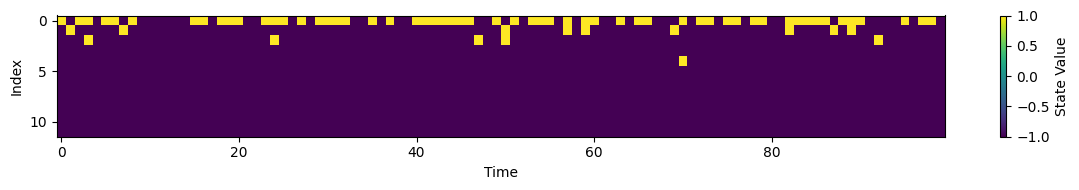

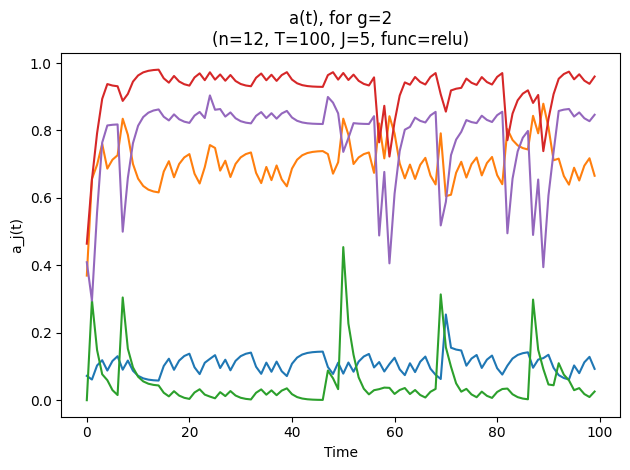

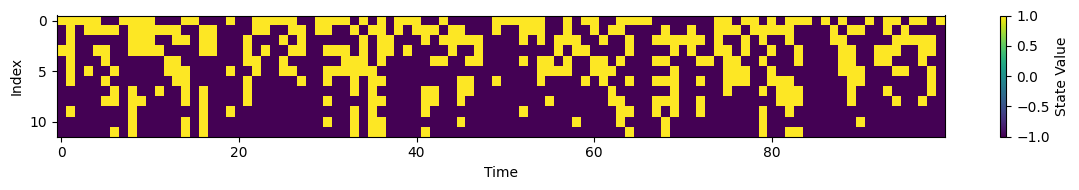

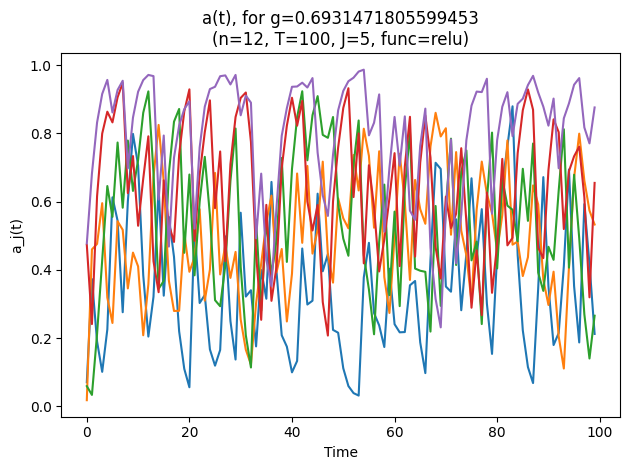

In [4]:
func = "step"
# Sample from the model
def sample_from_HFM(n, g, T):

    states, probs = H_model_distribution(n, g)
    indices = np.random.choice(len(states), size=T, p=probs)
    samples = np.array([states[i] for i in indices])
    # Transform states from {0,1} to {-1,+1}
    samples = 2 * samples - 1
    assert np.all(np.isin(samples, [-1, 1])), "States must be -1 or +1"
    return samples

def activation(z, func=func):
    """
        Type of activation function: "step", "sigmoid", "tanh", or "relu"
    """
    if func == "step":  # Perceptron
        return np.where(z >= 0, 1.0, -1.0)
    elif func == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    else:
        raise ValueError("Activation function not recognized")


def awareness_layers(S, J=20, eps=0):
    """
    Compute layer dynamics with Gaussian weights
    """
    T, n = S.shape
    A = np.zeros((T, J))
    
    # Initialize weights from N(0,1)
    W = np.random.normal(0, 1, (J, n))  # Shape: (J, n) for J layers and n inputs
    
    # Verify states are in {-1,+1}
    assert np.all(np.isin(S, [-1, 1])), "Input states must be -1 or +1"
    
    for j in range(J):
        a_j = 0.0  # Initialize layer j activity
        for t in range(T):
            input_sum = np.dot(W[j], S[t])  # W[j] shape: (n,), S[t] shape: (n,)
            out_val = activation(input_sum, func="sigmoid")
            a_j = (1 - eps) * a_j + eps * out_val
            A[t, j] = a_j
    
    return A

if __name__ == "__main__":
    # Fixed parameters
    n = 12      # length of each state
    T = 100     # number of time steps
    J = 5      # number of layers
    eps = 0.5
    func= "relu"

    # We'll explore 3 different values of g
    g_values = [0.0, 2, math.log(2.0)]

    # We'll store the mean time series for each g in a list
    mean_series_list = []

    for g in g_values:
        # 1) sample states S from HFM
        S = sample_from_HFM(n=n, g=g, T=T)
        # 2) compute awareness for J layers
        A = awareness_layers(S, J=J, eps=eps)
        plt.figure(figsize=(12, 2))
        plt.imshow(S.T, aspect='auto', interpolation='none')
        plt.colorbar(label='State Value')
        plt.xlabel('Time')
        plt.ylabel('Index')
        # Add grid
        plt.grid(False)
        plt.tight_layout()
        plt.show()
        # 3) Plot each layer's time series (WITHOUT the mean)
        plt.figure()
        for j in range(J):
            plt.plot(A[:, j], label=f"Layer {j}")

        plt.title(f"a(t), for g={g}\n"
                  f"(n={n}, T={T}, J={J}, func={func})")
        plt.xlabel("Time")
        plt.ylabel("a_j(t)")
        plt.tight_layout()
        plt.show()


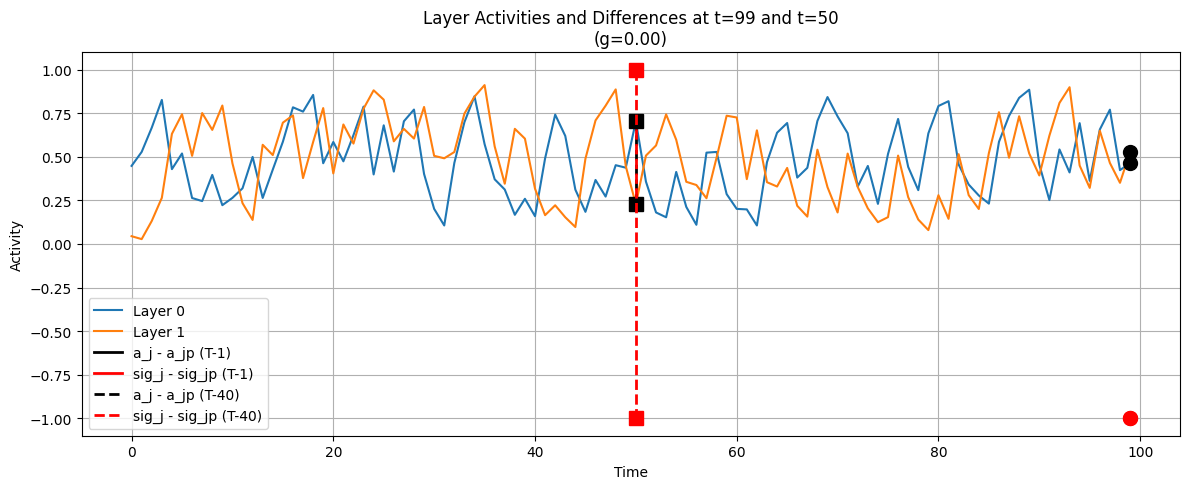

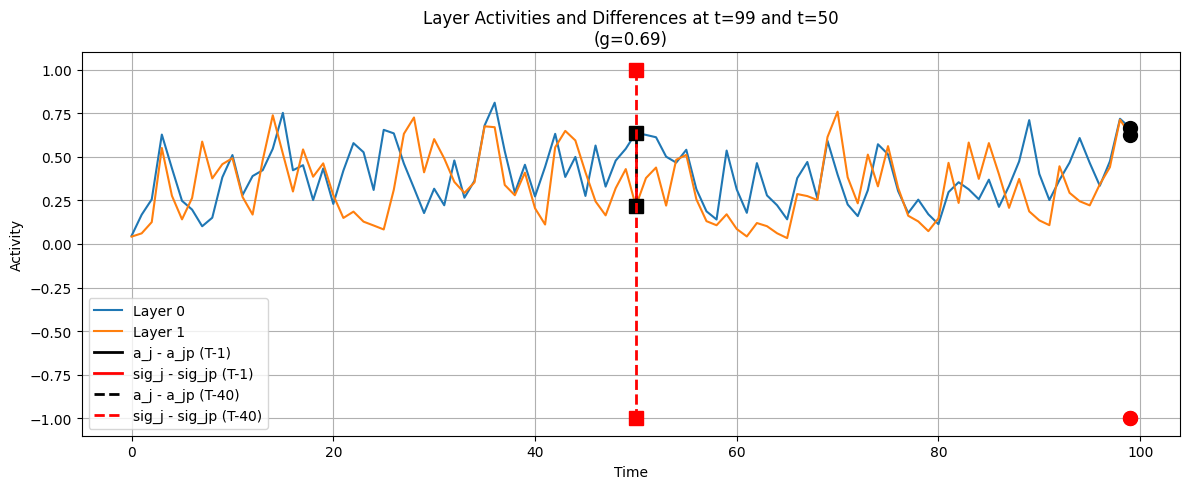

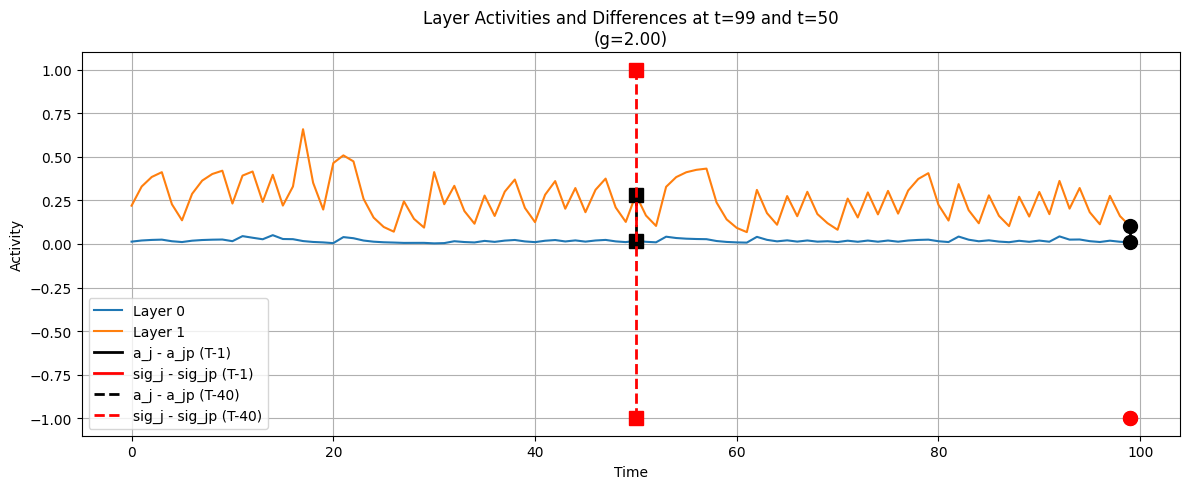

In [7]:
func = "step"
def awareness_measure_Y(S, A, W, func="sigmoid"):
    """
    Computes the awareness interaction measure Y for a given set of activations A, weights W, and states S.
    """
    T, J = A.shape
    Y_values = np.zeros(T)

    for t in range(T):
        Y_t = 0.0
        for j in range(J):
            for j_prime in range(j + 1, J):
                # Activations at time t
                a_j = A[t, j]
                a_jp = A[t, j_prime]

                # Inputs to activations (raw dot products)
                dot_j = np.dot(W[j], S[t])
                dot_jp = np.dot(W[j_prime], S[t])

                # Apply activation function to raw input
                sig_j = activation(dot_j, func=func)
                sig_jp = activation(dot_jp, func=func)

                # Compute the contribution to Y_t
                Y_t += (a_j - a_jp) * (sig_j - sig_jp)
        Y_values[t] = Y_t
    return Y_values

# Compute and plot Y for different g values
g_values = [0.0, math.log(2.0), 2.0]

for i, g in enumerate(g_values):
    J=2
    # 1) Sample states from HFM
    S = sample_from_HFM(n=n, g=g, T=T)
    
    # 2) Compute awareness for J layers
    A = awareness_layers(S, J=J, eps=eps)
    
    # 3) Compute awareness measure Y and components
    W = np.random.normal(0, 1, (J, n))
    
    # Select two specific layers to compare (e.g. layer 0 and 1)
    j, j_prime = 0, 1
    
    # Calculate final values at t=T-1
    t_final = T-1
    t_2 = T-50    
    # Calculate a_j and a_jp at t=T-1 and t_2
    a_j_final = A[t_final, j]
    a_jp_final = A[t_final, j_prime]
    a_j_2 = A[t_2, j]
    a_jp_2 = A[t_2, j_prime]
    
    # Calculate sig_j and sig_jp at t=T-1 and t_2
    dot_j_final = np.dot(W[j], S[t_final])
    dot_jp_final = np.dot(W[j_prime], S[t_final])
    sig_j_final = activation(dot_j_final, func=func)
    sig_jp_final = activation(dot_jp_final, func=func)
    
    dot_j_2 = np.dot(W[j], S[t_2])
    dot_jp_2 = np.dot(W[j_prime], S[t_2])
    sig_j_2 = activation(dot_j_2, func=func)
    sig_jp_2 = activation(dot_jp_2, func=func)
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Plot all layers
    for layer in range(J):
        plt.plot(A[:, layer], label=f"Layer {layer}")
    
    # Plot points and line for a_j - a_jp at t=T-1
    plt.plot([t_final, t_final], [a_jp_final, a_j_final], 'k-', linewidth=2, label='a_j - a_jp (T-1)')
    plt.plot(t_final, a_j_final, 'ko', markersize=10)
    plt.plot(t_final, a_jp_final, 'ko', markersize=10)
    
    # Plot points and line for sig_j - sig_jp at t=T-1
    plt.plot([t_final, t_final], [sig_jp_final, sig_j_final], 'r-', linewidth=2, label='sig_j - sig_jp (T-1)')
    plt.plot(t_final, sig_j_final, 'ro', markersize=10)
    plt.plot(t_final, sig_jp_final, 'ro', markersize=10)
    
    # Plot points and line for a_j - a_jp at t_2
    plt.plot([t_2, t_2], [a_jp_2, a_j_2], 'k--', linewidth=2, label='a_j - a_jp (T-40)')
    plt.plot(t_2, a_j_2, 'ks', markersize=10)
    plt.plot(t_2, a_jp_2, 'ks', markersize=10)
    
    # Plot points and line for sig_j - sig_jp at t_2
    plt.plot([t_2, t_2], [sig_jp_2, sig_j_2], 'r--', linewidth=2, label='sig_j - sig_jp (T-40)')
    plt.plot(t_2, sig_j_2, 'rs', markersize=10)
    plt.plot(t_2, sig_jp_2, 'rs', markersize=10)
    
    plt.title(f"Layer Activities and Differences at t={t_final} and t={t_2}\n(g={g:.2f})")
    plt.xlabel("Time")
    plt.ylabel("Activity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

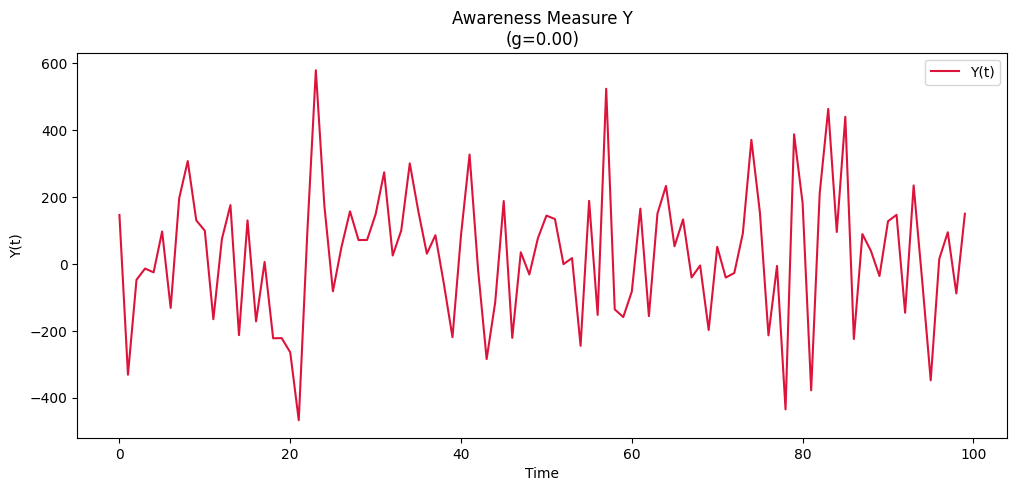

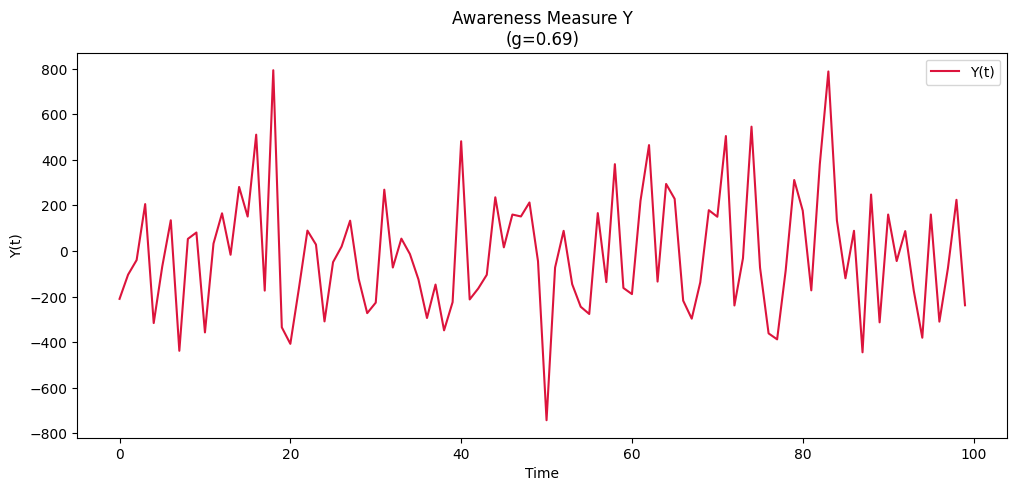

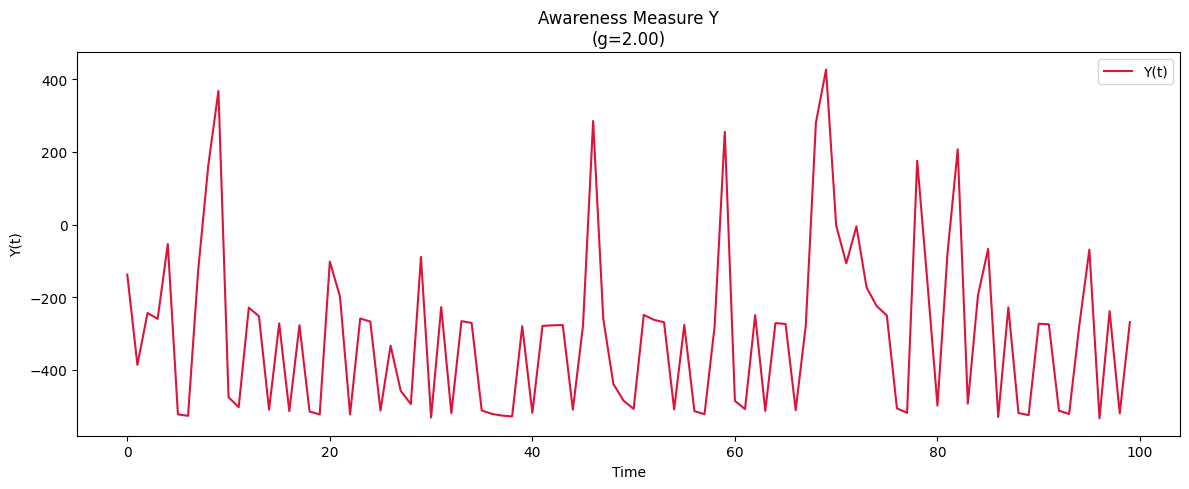

In [11]:
def awareness_measure_Y(S, A, W, func="sigmoid"):
    """
    Computes the awareness interaction measure Y for a given set of activations A, weights W, and states S.
    """
    T, J = A.shape
    Y_values = np.zeros(T)

    for t in range(T):
        Y_t = 0.0
        for j in range(J):
            for j_prime in range(j + 1, J):
                # Activations at time t
                a_j = A[t, j]
                a_jp = A[t, j_prime]

                # Inputs to activations (raw dot products)
                dot_j = np.dot(W[j], S[t])
                dot_jp = np.dot(W[j_prime], S[t])

                # Apply activation function to raw input
                sig_j = activation(dot_j, func=func)
                sig_jp = activation(dot_jp, func=func)

                # Compute the contribution to Y_t
                Y_t += (a_j - a_jp) * (sig_j - sig_jp)
        Y_values[t] = Y_t
    return Y_values

# Compute and plot Y for different g values
g_values = [0.0, math.log(2.0), 2.0]

for i, g in enumerate(g_values):
    J=100
    
    # 1) Sample states from HFM
    S = sample_from_HFM(n=n, g=g, T=T)
    
    # 2) Compute awareness for J layers
    A = awareness_layers(S, J=J, eps=eps)
    
    # 3) Compute awareness measure Y
    W = np.random.normal(0, 1, (J, n))  # same W used in awareness_layers
    Y_vals = awareness_measure_Y(S, A, W, func=func)
    # Plot Y in subplot
    plt.figure(figsize=(12, 5))
    plt.plot(Y_vals, color='crimson', label='Y(t)')
    plt.title(f"Awareness Measure Y\n(g={g:.2f})")
    plt.xlabel("Time")
    plt.ylabel("Y(t)")
    plt.legend()

plt.tight_layout()
plt.show()


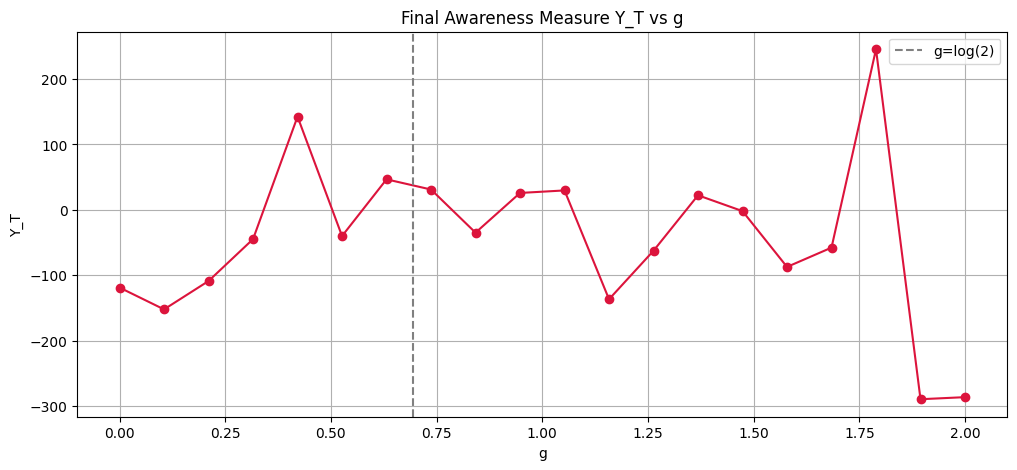

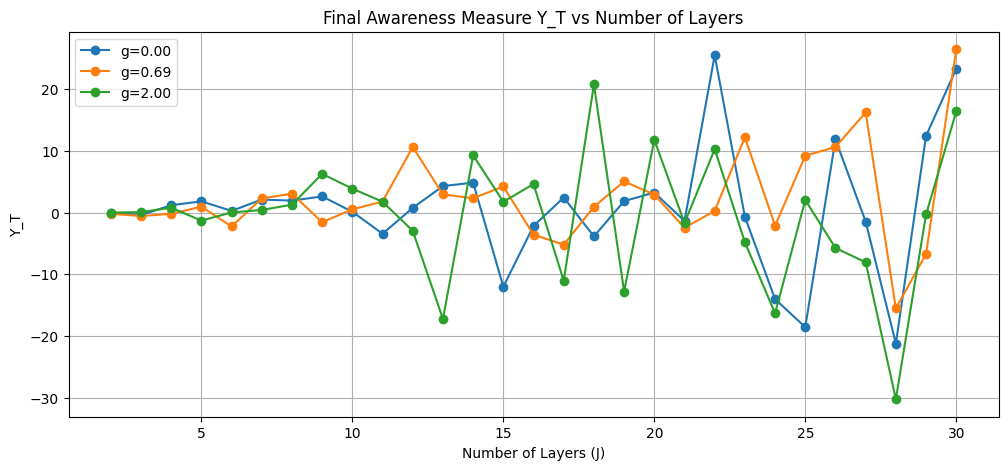

In [12]:
def awareness_measure_Y_final(S, A, W, func="sigmoid"):
    """
    Computes the final value Y_T of the awareness interaction measure.
    Returns only the last timestep value.
    """
    T, J = A.shape
    t = T-1  # Get final timestep
    Y_T = 0.0
    for j in range(J):
        for j_prime in range(j + 1, J):
            # Activations at final time T
            a_j = A[t, j]
            a_jp = A[t, j_prime]

            # Inputs to activations (raw dot products)
            dot_j = np.dot(W[j], S[t])
            dot_jp = np.dot(W[j_prime], S[t])

            # Apply activation function to raw input
            sig_j = activation(dot_j, func=func)
            sig_jp = activation(dot_jp, func=func)

            # Compute the contribution to Y_T
            Y_T += (a_j - a_jp) * (sig_j - sig_jp)
    return Y_T

# 1) Plot Y vs g
g_range = np.linspace(0, 2, 20)  # 20 points from 0 to 2
Y_vs_g = []

for g in g_range:
    S = sample_from_HFM(n=n, g=g, T=T)
    A = awareness_layers(S, J=J, eps=eps)
    W = np.random.normal(0, 1, (J, n))
    Y_T = awareness_measure_Y_final(S, A, W, func="sigmoid")
    Y_vs_g.append(Y_T)

plt.figure(figsize=(12, 5))
plt.plot(g_range, Y_vs_g, 'o-', color='crimson')
plt.axvline(x=math.log(2), color='gray', linestyle='--', label='g=log(2)')
plt.title("Final Awareness Measure Y_T vs g")
plt.xlabel("g")
plt.ylabel("Y_T")
plt.legend()
plt.grid(True)
plt.show()

# 2) Plot Y vs number of layers for fixed g values
g_values = [0.0, math.log(2.0), 2.0]
J_range = range(2, 31)  # From 2 to 30 layers
Y_vs_J = {g: [] for g in g_values}

for g in g_values:
    S = sample_from_HFM(n=n, g=g, T=T)
    for J_test in J_range:
        A = awareness_layers(S, J=J_test, eps=eps)
        W = np.random.normal(0, 1, (J_test, n))
        Y_T = awareness_measure_Y_final(S, A, W, func="sigmoid")
        Y_vs_J[g].append(Y_T)

plt.figure(figsize=(12, 5))
for g in g_values:
    plt.plot(list(J_range), Y_vs_J[g], 'o-', label=f'g={g:.2f}')
plt.title("Final Awareness Measure Y_T vs Number of Layers")
plt.xlabel("Number of Layers (J)")
plt.ylabel("Y_T")
plt.legend()
plt.grid(True)
plt.show()


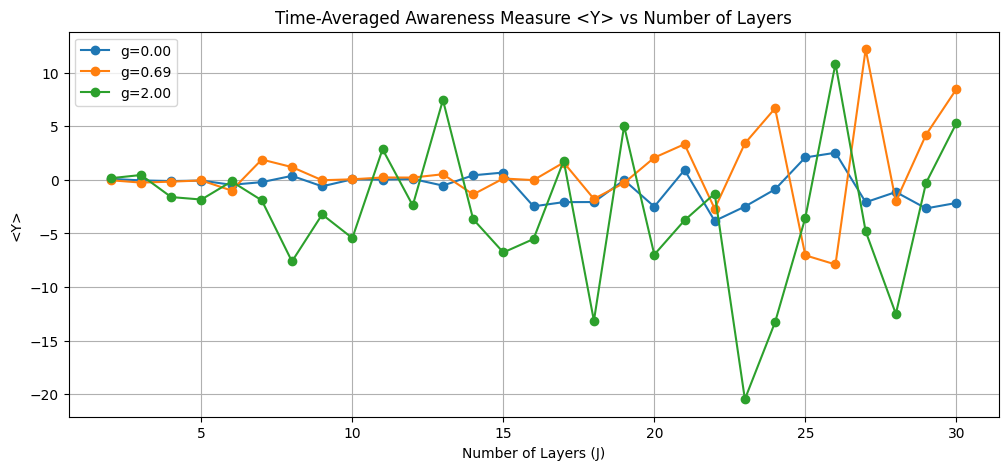

In [13]:
# 3) Plot <Y> = Sum_t Y_t/T vs J for fixed g values
g_values = [0.0, math.log(2.0), 2.0]
J_range = range(2, 31)  # From 2 to 30 layers
Y_avg_vs_J = {g: [] for g in g_values}

for g in g_values:
    S = sample_from_HFM(n=n, g=g, T=T)
    for J_test in J_range:
        A = awareness_layers(S, J=J_test, eps=eps)
        W = np.random.normal(0, 1, (J_test, n))
        
        # Calculate Y_t for all timesteps
        Y_t = np.array([compute_layer_correlation(S, W, A, t) for t in range(T)])
        # Calculate time average
        Y_avg = np.mean(Y_t)
        
        Y_avg_vs_J[g].append(Y_avg)

plt.figure(figsize=(12, 5))
for g in g_values:
    plt.plot(list(J_range), Y_avg_vs_J[g], 'o-', label=f'g={g:.2f}')
plt.title("Time-Averaged Awareness Measure <Y> vs Number of Layers")
plt.xlabel("Number of Layers (J)")
plt.ylabel("<Y>")
plt.legend()
plt.grid(True)
plt.show()


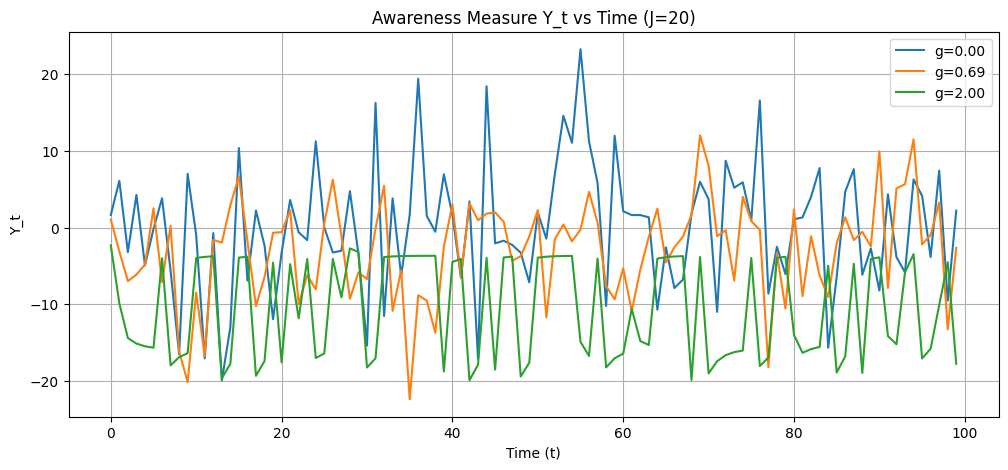

In [17]:
# 4) Plot Y_t vs t for fixed g values and J
g_values = [0.0, math.log(2.0), 2.0]
J = 20  # Fixed number of layers

plt.figure(figsize=(12, 5))
for g in g_values:
    S = sample_from_HFM(n=n, g=g, T=T)
    A = awareness_layers(S, J=J, eps=eps)
    W = np.random.normal(0, 1, (J, n))
    
    # Calculate Y_t for all timesteps
    Y_t = np.array([compute_layer_correlation(S, W, A, t) for t in range(T)])
    
    plt.plot(Y_t, label=f'g={g:.2f}')

plt.title(f"Awareness Measure Y_t vs Time (J={J})")
plt.xlabel("Time (t)")
plt.ylabel("Y_t")
plt.legend()
plt.grid(True)
plt.show()
